In [3]:
from xfoil import XFoil
from xfoil.model import Airfoil
from xfoil.test import naca0012

from scipy import interpolate
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg

from pathlib import Path
import numpy as np
import os
import gc

from config import *
from lib.utils import *
from lib.preprocess_modules import *

## Part 1

### Create pickle files with airfoils

Convert airfoils .dat files to pickle files with following structure:

#### Dict {}:

    'x_raw' - source x coordinate from .dat file.
    'y_raw' - source y coordinate from .dat file.
    'X_raw' - array of n_foil_params * n_points_Re * n_points_alfa size , with NaN for XFoil failed points.
    'X'     - array of n_foil_params * n_points_Re * n_points_alfa size , with interpolated XFoil failed points.
    'y'     - Xfoil.Airfoil object with classes 'coords','n_coords','x','y'. Used for generation of tagret array.
    'd'     - foil aileron thickness.
    'S'     - foil root thickness.
    
Save .pkl files to **foils_pkl_path** folder.

In [5]:
run_foils = 2000

# get list of alfas and alfa step
alfa_step, alfas = get_alfa_step(alfa_min, alfa_max, n_points_alfa)

# set list of Re's
Re = np.linspace(re_min, re_max, n_points_Re).astype(int)

print("Alfas:", alfas)
print("Re's:", Re)

foils_counter = 0

for fname in os.listdir(foils_dat_path):
    
    foils_counter += 1
    
    # check whether the foil analyzed already
    if fname.replace(".dat", ".pkl") in os.listdir(foils_pkl_path):
        print(foils_counter, 'Work on', fname, "     --> Foil's pkl file already exists, skipping.")
        continue
    else:
        print(foils_counter, 'Work on', fname)
    
    # set up result dictionary
    foil_output = {}
    
    # set up foil data array
    foil_array = np.zeros((n_foil_params, n_points_Re, n_points_alfa))
    pre_foil_array = np.zeros((n_foil_params, n_points_Re, n_points_alfa))
        
    # load foil coords from file
    try:
        x, y = read_airfoil_dat_file(Path(foils_dat_path, fname))
    except:
        print("W: Foil %s failed to read from file, skipped." % (fname))
        continue
    
    # keep in output dict
    foil_output['x_raw'] = x
    foil_output['y_raw'] = y
    
    # convert coords to n_foil_points
    try:
        x, y = interpolate_airfoil(x, y, n_foil_points)
    except:
        print("W: Foil %s failed to interpolate to %i points, skipped." % (fname, n_foil_points))
        continue
    
    # set an Airfoil object on these coords
    current_foil = Airfoil(x,y)
    
    # get root and flap thicknesses 
    try:
        d = get_foil_flap_thickness(current_foil)
        S = get_foil_root_thickness(current_foil) 
    except:
        print("W: Foil %s failed to get thicknesses, skipped." % (fname))
        continue     

    # store in ary
    foil_array[4, :, :] = d
    foil_array[5, :, :] = S    

    # setup xfoil lib
    xf = XFoil()
    xf.airfoil = current_foil
    xf.max_iter = xfoil_max_iterations

    # xfoiling for each Re
    for num in range(16):
        
        xf.Re = Re[num]        
        a, cl, cd, cm, cp = xf.aseq(alfa_min, alfa_max, alfa_step)  
        
        assert (len(a)==n_points_alfa), "Lenght of alfa array is wrong!"
        
        nans_percent = sum(np.isnan(a))/len(a)
        
        # interpolate gaps in alfa plane
        if nans_percent < max_nans_in_curve:            
            cl = fill_gaps_in_xfoil_curve(cl)
            cd = fill_gaps_in_xfoil_curve(cd)
            cm = fill_gaps_in_xfoil_curve(cm)
            cp = fill_gaps_in_xfoil_curve(cp)
        
        # write results to main array
        foil_array[0, num, :] = cl
        foil_array[1, num, :] = cd
        foil_array[2, num, :] = cm
        foil_array[3, num, :] = cp
        foil_array[6, num, :] = Re[num]
        foil_array[7, num, :] = alfas
        
        # write results to debug array
        pre_foil_array[0, num, :] = cl
        pre_foil_array[1, num, :] = cd
        pre_foil_array[2, num, :] = cm
        pre_foil_array[3, num, :] = cp
        pre_foil_array[6, num, :] = Re[num]
        pre_foil_array[7, num, :] = alfas
       
        # interpolate gaps in Re plane
        for alfa in range(32):
            foil_array[0, :, alfa] = fill_gaps_in_xfoil_curve(foil_array[0, :, alfa])
            foil_array[1, :, alfa] = fill_gaps_in_xfoil_curve(foil_array[1, :, alfa])
            foil_array[2, :, alfa] = fill_gaps_in_xfoil_curve(foil_array[2, :, alfa])
            foil_array[3, :, alfa] = fill_gaps_in_xfoil_curve(foil_array[3, :, alfa])            
            
    # save or discard data
    if np.sum(np.isnan(foil_array))==0:
        
        # fill output dict
        foil_output['X'] = foil_array
        foil_output['X_raw'] = pre_foil_array
        foil_output['y'] = current_foil
        foil_output['d'] = d
        foil_output['S'] = S
        
        # save file
        pkl_name = fname.replace(".dat", ".pkl")
        save_pkl(foil_output, Path(foils_pkl_path, pkl_name))        
        print("     --> %i NaNs corrected, file %s saved." % (int(np.sum(np.isnan(pre_foil_array))), pkl_name))
        
    else:
        
        print("W: Foil skipped - %i NaNs in foil_array." % int(np.sum(np.isnan(foil_array))))
        
        

    if foils_counter > run_foils: raise Exception("Required number of processed foils exceeded:", run_foils)        

Alfas: [-2.0999999  -1.78437495 -1.46874988 -1.15312481 -0.83749986 -0.52187485
 -0.20624983  0.10937518  0.42500019  0.7406252   1.05625021  1.37187529
  1.68750024  2.00312519  2.31875014  2.63437533  2.95000029  3.26562524
  3.58125043  3.89687538  4.2125001   4.52812529  4.84375048  5.15937519
  5.47500038  5.79062557  6.10625029  6.42187548  6.73750019  7.05312538
  7.36875057  7.68437529]
Re's: [ 40000  50666  61333  72000  82666  93333 104000 114666 125333 136000
 146666 157333 168000 178666 189333 200000]
1 Work on 2032c.dat      --> Foil's pkl file already exists, skipping.
2 Work on a18.dat      --> Foil's pkl file already exists, skipping.
3 Work on a18sm.dat      --> Foil's pkl file already exists, skipping.
4 Work on a63a108c.dat      --> Foil's pkl file already exists, skipping.
5 Work on ag03.dat      --> Foil's pkl file already exists, skipping.
6 Work on ag04.dat      --> Foil's pkl file already exists, skipping.
7 Work on ag08.dat      --> Foil's pkl file already exis

     --> 0 NaNs corrected, file daytonwrightt1.pkl saved.
153 Work on dbln526.dat
     --> 1908 NaNs corrected, file dbln526.pkl saved.
154 Work on defcnd1.dat
     --> 0 NaNs corrected, file defcnd1.pkl saved.
155 Work on defcnd2.dat
     --> 0 NaNs corrected, file defcnd2.pkl saved.
156 Work on defcnd3.dat
     --> 0 NaNs corrected, file defcnd3.pkl saved.
157 Work on df101.dat
     --> 0 NaNs corrected, file df101.pkl saved.
158 Work on df102.dat
     --> 0 NaNs corrected, file df102.pkl saved.
159 Work on dfvlrr4.dat
     --> 0 NaNs corrected, file dfvlrr4.pkl saved.
160 Work on dga1138.dat
     --> 0 NaNs corrected, file dga1138.pkl saved.
161 Work on dga1182.dat
     --> 128 NaNs corrected, file dga1182.pkl saved.
162 Work on dh4009sm.dat
     --> 692 NaNs corrected, file dh4009sm.pkl saved.
163 Work on doa5.dat
     --> 0 NaNs corrected, file doa5.pkl saved.
164 Work on dormoy.dat
     --> 0 NaNs corrected, file dormoy.pkl saved.
165 Work on drgnfly.dat
     --> 1072 NaNs correc

     --> 0 NaNs corrected, file e475.pkl saved.
269 Work on e476.dat
     --> 0 NaNs corrected, file e476.pkl saved.
270 Work on e477.dat
     --> 0 NaNs corrected, file e477.pkl saved.
271 Work on e478.dat
     --> 0 NaNs corrected, file e478.pkl saved.
272 Work on e479.dat
     --> 0 NaNs corrected, file e479.pkl saved.
273 Work on e485.dat
     --> 0 NaNs corrected, file e485.pkl saved.
274 Work on e49.dat
     --> 1452 NaNs corrected, file e49.pkl saved.
275 Work on e502.dat
     --> 0 NaNs corrected, file e502.pkl saved.
276 Work on e520.dat
     --> 0 NaNs corrected, file e520.pkl saved.
277 Work on e521.dat
     --> 0 NaNs corrected, file e521.pkl saved.
278 Work on e540.dat
     --> 88 NaNs corrected, file e540.pkl saved.
279 Work on e541.dat
     --> 0 NaNs corrected, file e541.pkl saved.
280 Work on e542.dat
     --> 0 NaNs corrected, file e542.pkl saved.
281 Work on e543.dat
     --> 0 NaNs corrected, file e543.pkl saved.
282 Work on e544.dat
     --> 0 NaNs corrected, file 

     --> 804 NaNs corrected, file fg1.pkl saved.
386 Work on fg2.dat
     --> 364 NaNs corrected, file fg2.pkl saved.
387 Work on fg3.dat
     --> 876 NaNs corrected, file fg3.pkl saved.
388 Work on fg4.dat
     --> 256 NaNs corrected, file fg4.pkl saved.
389 Work on fx049915.dat
     --> 128 NaNs corrected, file fx049915.pkl saved.
390 Work on fx05188.dat
     --> 164 NaNs corrected, file fx05188.pkl saved.
391 Work on fx05191.dat
     --> 0 NaNs corrected, file fx05191.pkl saved.
392 Work on fx057816.dat
     --> 0 NaNs corrected, file fx057816.pkl saved.
393 Work on fx05h126.dat
     --> 492 NaNs corrected, file fx05h126.pkl saved.
394 Work on fx082512.dat
     --> 0 NaNs corrected, file fx082512.pkl saved.
395 Work on fx08s176.dat
     --> 596 NaNs corrected, file fx08s176.pkl saved.
396 Work on fx2.dat
     --> 0 NaNs corrected, file fx2.pkl saved.
397 Work on fx3.dat
     --> 2048 NaNs corrected, file fx3.pkl saved.
398 Work on fx38153.dat
     --> 0 NaNs corrected, file fx38153.

     --> 92 NaNs corrected, file fx83w227.pkl saved.
492 Work on fx84w097.dat
     --> 0 NaNs corrected, file fx84w097.pkl saved.
493 Work on fx84w127.dat
     --> 0 NaNs corrected, file fx84w127.pkl saved.
494 Work on fx84w140.dat
     --> 0 NaNs corrected, file fx84w140.pkl saved.
495 Work on fx84w150.dat
     --> 0 NaNs corrected, file fx84w150.pkl saved.
496 Work on fx84w175.dat
     --> 80 NaNs corrected, file fx84w175.pkl saved.
497 Work on fx84w218.dat
     --> 80 NaNs corrected, file fx84w218.pkl saved.
498 Work on fxl142k.dat
     --> 0 NaNs corrected, file fxl142k.pkl saved.
499 Work on fxlv152.dat
W: Foil fxlv152.dat failed to interpolate to 128 points, skipped.
500 Work on fxm2.dat
     --> 512 NaNs corrected, file fxm2.pkl saved.
501 Work on fxs02196.dat
     --> 0 NaNs corrected, file fxs02196.pkl saved.
502 Work on fxs03182.dat
     --> 0 NaNs corrected, file fxs03182.pkl saved.
503 Work on fxs21158.dat
     --> 0 NaNs corrected, file fxs21158.pkl saved.
504 Work on gemi

     --> 860 NaNs corrected, file goe274.pkl saved.
602 Work on goe275.dat
     --> 576 NaNs corrected, file goe275.pkl saved.
603 Work on goe276.dat
     --> 216 NaNs corrected, file goe276.pkl saved.
604 Work on goe277.dat
     --> 248 NaNs corrected, file goe277.pkl saved.
605 Work on goe278.dat
     --> 692 NaNs corrected, file goe278.pkl saved.
606 Work on goe279.dat
     --> 676 NaNs corrected, file goe279.pkl saved.
607 Work on goe280.dat
     --> 940 NaNs corrected, file goe280.pkl saved.
608 Work on goe281.dat
     --> 584 NaNs corrected, file goe281.pkl saved.
609 Work on goe282.dat
     --> 128 NaNs corrected, file goe282.pkl saved.
610 Work on goe284.dat
     --> 0 NaNs corrected, file goe284.pkl saved.
611 Work on goe285.dat
     --> 0 NaNs corrected, file goe285.pkl saved.
612 Work on goe286.dat
     --> 0 NaNs corrected, file goe286.pkl saved.
613 Work on goe287.dat
     --> 484 NaNs corrected, file goe287.pkl saved.
614 Work on goe288.dat
     --> 0 NaNs corrected, file

     --> 0 NaNs corrected, file goe421.pkl saved.
713 Work on goe422.dat
     --> 0 NaNs corrected, file goe422.pkl saved.
714 Work on goe423.dat
     --> 0 NaNs corrected, file goe423.pkl saved.
715 Work on goe424.dat
     --> 0 NaNs corrected, file goe424.pkl saved.
716 Work on goe425.dat
     --> 0 NaNs corrected, file goe425.pkl saved.
717 Work on goe426.dat
     --> 0 NaNs corrected, file goe426.pkl saved.
718 Work on goe427.dat
     --> 128 NaNs corrected, file goe427.pkl saved.
719 Work on goe428.dat
     --> 256 NaNs corrected, file goe428.pkl saved.
720 Work on goe429.dat
     --> 0 NaNs corrected, file goe429.pkl saved.
721 Work on goe430.dat
     --> 0 NaNs corrected, file goe430.pkl saved.
722 Work on goe431.dat
     --> 236 NaNs corrected, file goe431.pkl saved.
723 Work on goe432.dat
     --> 0 NaNs corrected, file goe432.pkl saved.
724 Work on goe433.dat
     --> 0 NaNs corrected, file goe433.pkl saved.
725 Work on goe434.dat
     --> 0 NaNs corrected, file goe434.pkl sa

     --> 616 NaNs corrected, file goe574.pkl saved.
825 Work on goe575.dat
     --> 0 NaNs corrected, file goe575.pkl saved.
826 Work on goe584.dat
     --> 0 NaNs corrected, file goe584.pkl saved.
827 Work on goe585.dat
     --> 0 NaNs corrected, file goe585.pkl saved.
828 Work on goe587.dat
     --> 0 NaNs corrected, file goe587.pkl saved.
829 Work on goe590.dat
     --> 128 NaNs corrected, file goe590.pkl saved.
830 Work on goe591.dat
     --> 128 NaNs corrected, file goe591.pkl saved.
831 Work on goe592.dat
     --> 200 NaNs corrected, file goe592.pkl saved.
832 Work on goe593.dat
     --> 0 NaNs corrected, file goe593.pkl saved.
833 Work on goe595.dat
     --> 0 NaNs corrected, file goe595.pkl saved.
834 Work on goe596.dat
     --> 0 NaNs corrected, file goe596.pkl saved.
835 Work on goe598.dat
     --> 0 NaNs corrected, file goe598.pkl saved.
836 Work on goe599.dat
     --> 0 NaNs corrected, file goe599.pkl saved.
837 Work on goe600.dat
     --> 0 NaNs corrected, file goe600.pkl 

     --> 0 NaNs corrected, file hq1585.pkl saved.
937 Work on hq159.dat
     --> 0 NaNs corrected, file hq159.pkl saved.
938 Work on hq159b.dat
     --> 0 NaNs corrected, file hq159b.pkl saved.
939 Work on hq2010.dat
     --> 0 NaNs corrected, file hq2010.pkl saved.
940 Work on hq2012.dat
     --> 0 NaNs corrected, file hq2012.pkl saved.
941 Work on hq208.dat
     --> 0 NaNs corrected, file hq208.pkl saved.
942 Work on hq209.dat
     --> 0 NaNs corrected, file hq209.pkl saved.
943 Work on hq2090sm.dat
     --> 0 NaNs corrected, file hq2090sm.pkl saved.
944 Work on hq2195.dat
     --> 0 NaNs corrected, file hq2195.pkl saved.
945 Work on hq2510.dat
     --> 0 NaNs corrected, file hq2510.pkl saved.
946 Work on hq2511.dat
     --> 0 NaNs corrected, file hq2511.pkl saved.
947 Work on hq2512.dat
     --> 0 NaNs corrected, file hq2512.pkl saved.
948 Work on hq258.dat
     --> 236 NaNs corrected, file hq258.pkl saved.
949 Work on hq259.dat
     --> 0 NaNs corrected, file hq259.pkl saved.
950 W

     --> 0 NaNs corrected, file mb253515sm.pkl saved.
1051 Work on mh102.dat
     --> 0 NaNs corrected, file mh102.pkl saved.
1052 Work on mh104.dat
     --> 0 NaNs corrected, file mh104.pkl saved.
1053 Work on mh106.dat
     --> 0 NaNs corrected, file mh106.pkl saved.
1054 Work on mh108.dat
     --> 0 NaNs corrected, file mh108.pkl saved.
1055 Work on mh110.dat
     --> 0 NaNs corrected, file mh110.pkl saved.
1056 Work on mh112.dat
     --> 0 NaNs corrected, file mh112.pkl saved.
1057 Work on mh113.dat
     --> 0 NaNs corrected, file mh113.pkl saved.
1058 Work on mh114.dat
     --> 0 NaNs corrected, file mh114.pkl saved.
1059 Work on mh115.dat
     --> 124 NaNs corrected, file mh115.pkl saved.
1060 Work on mh116.dat
     --> 0 NaNs corrected, file mh116.pkl saved.
1061 Work on mh117.dat
     --> 0 NaNs corrected, file mh117.pkl saved.
1062 Work on mh120.dat
     --> 0 NaNs corrected, file mh120.pkl saved.
1063 Work on mh121.dat
     --> 0 NaNs corrected, file mh121.pkl saved.
1064 Wor

     --> 88 NaNs corrected, file naca001066.pkl saved.
1163 Work on naca001234.dat
     --> 0 NaNs corrected, file naca001234.pkl saved.
1164 Work on naca001264.dat
     --> 0 NaNs corrected, file naca001264.pkl saved.
1165 Work on naca001264a08cli0.2.dat
     --> 248 NaNs corrected, file naca001264a08cli0.2.pkl saved.
1166 Work on naca0015.dat
     --> 0 NaNs corrected, file naca0015.pkl saved.
1167 Work on naca0018.dat
     --> 0 NaNs corrected, file naca0018.pkl saved.
1168 Work on naca0021.dat
     --> 0 NaNs corrected, file naca0021.pkl saved.
1169 Work on naca0024.dat
     --> 0 NaNs corrected, file naca0024.pkl saved.
1170 Work on naca1.dat
     --> 2048 NaNs corrected, file naca1.pkl saved.
1171 Work on naca1408.dat
     --> 0 NaNs corrected, file naca1408.pkl saved.
1172 Work on naca1410.dat
     --> 0 NaNs corrected, file naca1410.pkl saved.
1173 Work on naca1412.dat
     --> 0 NaNs corrected, file naca1412.pkl saved.
1174 Work on naca16006.dat
     --> 1020 NaNs corrected, f

     --> 0 NaNs corrected, file naca653218.pkl saved.
1235 Work on naca65410.dat
     --> 0 NaNs corrected, file naca65410.pkl saved.
1236 Work on naca654221.dat
     --> 0 NaNs corrected, file naca654221.pkl saved.
1237 Work on naca654421.dat
     --> 0 NaNs corrected, file naca654421.pkl saved.
1238 Work on naca654421a05.dat
     --> 80 NaNs corrected, file naca654421a05.pkl saved.
1239 Work on naca66-018.dat
     --> 0 NaNs corrected, file naca66-018.pkl saved.
1240 Work on naca661212.dat
     --> 0 NaNs corrected, file naca661212.pkl saved.
1241 Work on naca66206.dat
     --> 616 NaNs corrected, file naca66206.pkl saved.
1242 Work on naca66209.dat
     --> 456 NaNs corrected, file naca66209.pkl saved.
1243 Work on naca66210.dat
     --> 128 NaNs corrected, file naca66210.pkl saved.
1244 Work on naca662215.dat
     --> 0 NaNs corrected, file naca662215.pkl saved.
1245 Work on naca662415.dat
     --> 0 NaNs corrected, file naca662415.pkl saved.
1246 Work on naca663218.dat
     --> 0 

     --> 0 NaNs corrected, file rg12.pkl saved.
1343 Work on rg12a.dat
     --> 0 NaNs corrected, file rg12a.pkl saved.
1344 Work on rg12a189.dat
     --> 128 NaNs corrected, file rg12a189.pkl saved.
1345 Work on rg14.dat
     --> 0 NaNs corrected, file rg14.pkl saved.
1346 Work on rg1410.dat
     --> 0 NaNs corrected, file rg1410.pkl saved.
1347 Work on rg149.dat
     --> 0 NaNs corrected, file rg149.pkl saved.
1348 Work on rg1495.dat
     --> 0 NaNs corrected, file rg1495.pkl saved.
1349 Work on rg14a147.dat
     --> 384 NaNs corrected, file rg14a147.pkl saved.
1350 Work on rg15.dat
     --> 0 NaNs corrected, file rg15.pkl saved.
1351 Work on rg15a111.dat
     --> 0 NaNs corrected, file rg15a111.pkl saved.
1352 Work on rg15a213.dat
     --> 0 NaNs corrected, file rg15a213.pkl saved.
1353 Work on rg8.dat
     --> 0 NaNs corrected, file rg8.pkl saved.
1354 Work on rhodesg30.dat
     --> 0 NaNs corrected, file rhodesg30.pkl saved.
1355 Work on rhodesg32.dat
     --> 0 NaNs corrected, fi

     --> 0 NaNs corrected, file sd7003.pkl saved.
1454 Work on sd7032.dat
     --> 0 NaNs corrected, file sd7032.pkl saved.
1455 Work on sd7034.dat
     --> 0 NaNs corrected, file sd7034.pkl saved.
1456 Work on sd7037.dat
     --> 0 NaNs corrected, file sd7037.pkl saved.
1457 Work on sd7043.dat
     --> 0 NaNs corrected, file sd7043.pkl saved.
1458 Work on sd7062.dat
     --> 0 NaNs corrected, file sd7062.pkl saved.
1459 Work on sd7080.dat
     --> 0 NaNs corrected, file sd7080.pkl saved.
1460 Work on sd7084.dat
     --> 0 NaNs corrected, file sd7084.pkl saved.
1461 Work on sd7090.dat
     --> 0 NaNs corrected, file sd7090.pkl saved.
1462 Work on sd8000.dat
     --> 0 NaNs corrected, file sd8000.pkl saved.
1463 Work on sd8020.dat
     --> 0 NaNs corrected, file sd8020.pkl saved.
1464 Work on sd8040.dat
     --> 0 NaNs corrected, file sd8040.pkl saved.
1465 Work on sg6040.dat
     --> 0 NaNs corrected, file sg6040.pkl saved.
1466 Work on sg6041.dat
     --> 0 NaNs corrected, file sg6041

Foil name: ['naca4421.pkl'] 
Root thickness: 0.21, flap thickness: 0.13
Show curve: Cd


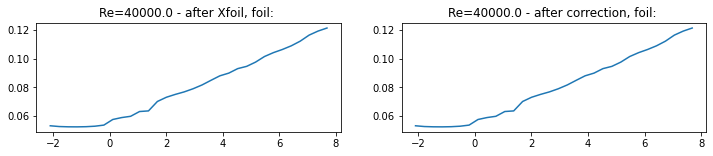

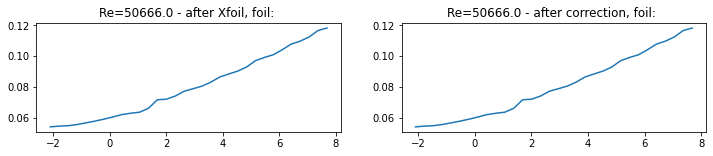

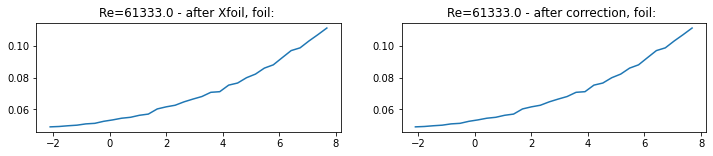

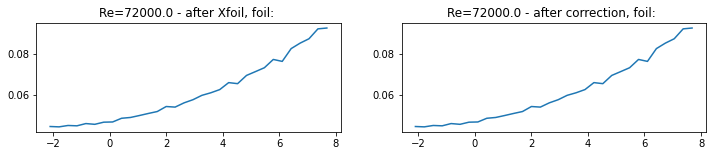

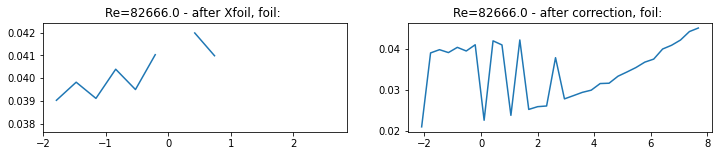

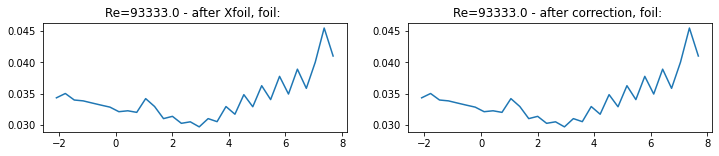

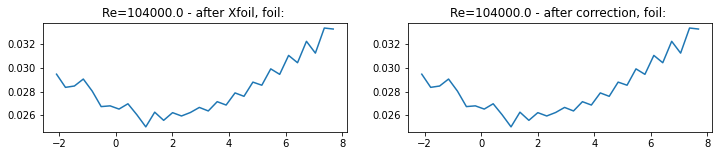

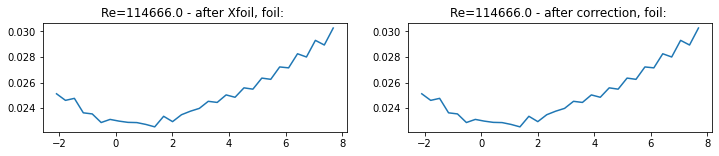

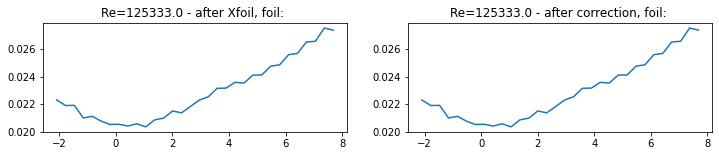

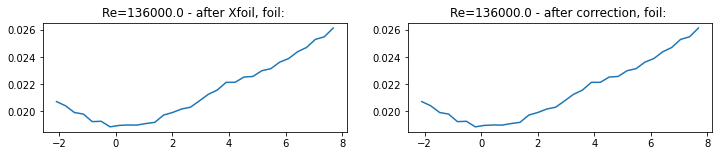

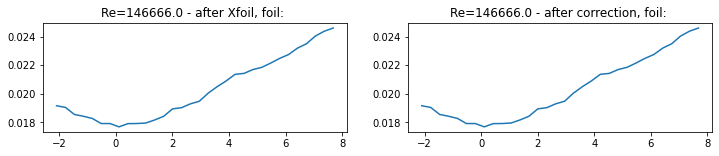

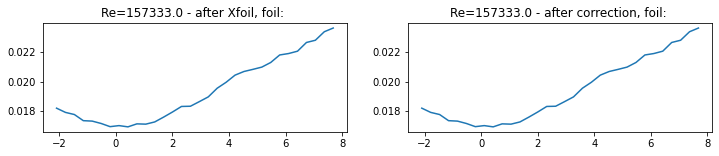

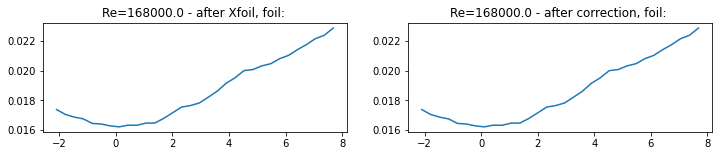

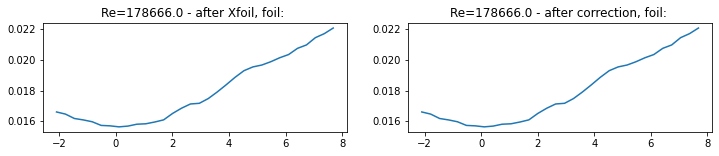

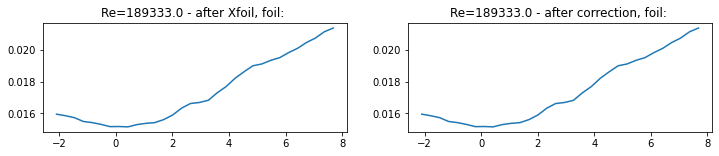

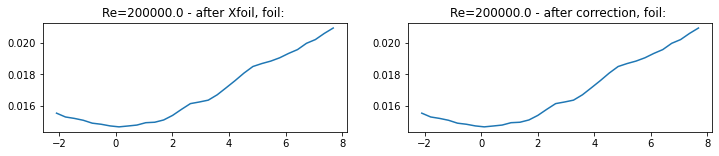

In [8]:
show_foil_info(Path(foils_pkl_path, "naca4421.pkl"), 'Cd')

## Part 2

### Generate target bitmaps

1. Create output folders as per **bitmap_outputs**
2. For each airfoil:
    - opens pickle file with airfoil data; 
    - reads raw foil x-y coordinates (as specified in initial .dat file);
    - interpolates it with **n_points_interpolate_for_bmp points**;
    - plots it to buffer with figsize as per **bitmap_outputs**;
    - saves as jpg file at **foils_bmp_path** of minimal resolution;
    - converts to boolean and saves as pickle file at respective resolution folder **foils_pkl_path**.

In [4]:
# find minimum required resolution and create output folders
output_folders=[]
min_resolution = 32768*32768
for res in bitmap_outputs:
    x = res[0]; y = res[1]
    output_folders.append(str(x)+'x'+str(y))
    if x*y<min_resolution: min_resolution = x*y 
print('Output jpegs resolution: %i*%i.' % (x, y))

for folder in output_folders:
    folder_path = Path(foils_bmp_path, folder)
    if not os.path.exists(folder_path): 
        try:
            os.mkdir(folder_path)
        except OSError:
            print ("Creation of the directory %s failed" % folder_path)

Output jpegs resolution: 512*512.


In [ ]:
for fname in os.listdir(foils_pkl_path):
    
    if '.pkl' in fname:   
        
        print('Work on %s ...' % fname)
        
        for bitmap_pixels_y, bitmap_pixels_x in bitmap_outputs:            
        
            # read foil
            foil = load_pkl(Path(foils_pkl_path, fname))
            fig_x = bitmap_pixels_x/zoom_coef
            fig_y = bitmap_pixels_y/zoom_coef
            
            # interpolate
            x, y = interpolate_airfoil(foil['x_raw'], foil['y_raw'], n_points_interpolate_for_bmp)

            # plot
            fig = plt.figure(figsize=(fig_x,fig_y),  frameon=False)
            canvas = FigureCanvasAgg(fig)
            ax = fig.add_axes([0.,0.,1.,1.])
            ax.fill(x, y, 'black')
            ax.axis('equal');
            ax.axis('off');
            s, (width, height) = canvas.print_to_buffer()
            
            # copy plot to array
            foil_bmp = np.array(np.frombuffer(s, np.uint8).reshape((height, width, 4))[:,:,0])

            if bitmap_pixels_x*bitmap_pixels_y == min_resolution:
            # save bmp file here
                plt.savefig(Path(foils_bmp_path, fname.replace('.pkl', '.jpg')))
                
            plt.close()
            
            # convert to bool
            foil_bmp[foil_bmp==0] = 1
            foil_bmp[foil_bmp==255] = 0
            foil_bmp = foil_bmp.astype('bool') 
            
            # save pkl array here            
            save_pkl(foil_bmp, Path(foils_bmp_path, str(bitmap_pixels_y)+'x'+str(bitmap_pixels_x), fname))
            
            gc.collect()
            
print('All done!')

Work on 2032c.pkl ...
Work on a18.pkl ...
Work on a18sm.pkl ...
Work on a63a108c.pkl ...
Work on ag03.pkl ...
Work on ag04.pkl ...
Work on ag08.pkl ...
Work on ag09.pkl ...
Work on ag10.pkl ...
Work on ag11.pkl ...
Work on ag12.pkl ...
Work on ag13.pkl ...
Work on ag14.pkl ...
Work on ag16.pkl ...
Work on ag17.pkl ...
Work on ag18.pkl ...
Work on ag19.pkl ...
Work on ag24.pkl ...
Work on ag25.pkl ...
Work on ag26.pkl ...
Work on ag27.pkl ...
Work on ag35.pkl ...
Work on ag36.pkl ...
Work on ag37.pkl ...
Work on ag38.pkl ...
Work on ag44ct02r.pkl ...
Work on ag455ct02r.pkl ...
Work on ag45c03.pkl ...
Work on ag45ct02r.pkl ...
Work on ag46c03.pkl ...
Work on ag46ct02r.pkl ...
Work on ag47c03.pkl ...
Work on ag47ct02r.pkl ...
Work on ah21-7.pkl ...
Work on ah21-9.pkl ...
Work on ah63k127.pkl ...
Work on ah6407.pkl ...
Work on ah7476.pkl ...
Work on ah79100a.pkl ...
Work on ah79100b.pkl ...
Work on ah79100c.pkl ...
Work on ah79k132.pkl ...
Work on ah79k135.pkl ...
Work on ah79k143.pkl ...


In [ ]:
# check pickle arrays shapes match to folders names
for folder in output_folders:
    for fname in os.listdir(Path(foils_bmp_path, folder)):
        fl = load_pkl(Path(foils_bmp_path, folder, fname))
        if str(fl.shape[0])+'x'+str(fl.shape[1])!=folder:
            print(Path(foils_bmp_path, folder, fname),'-', fl.shape)